In [93]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax #for some statistics
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split





In [44]:
# importing data
train=pd.read_csv('train.csv')

train.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [45]:
# displaying common data metrics
train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [46]:
# check for uniqueness
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1460 total entries


In [47]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']

train.drop(['Id'], axis=1, inplace=True)

train.shape

(1460, 80)

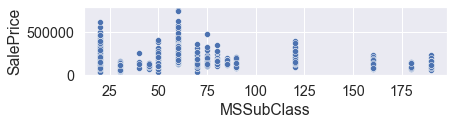

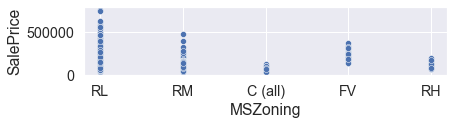

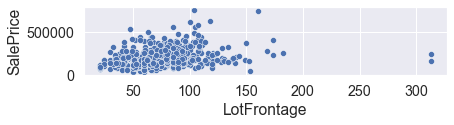

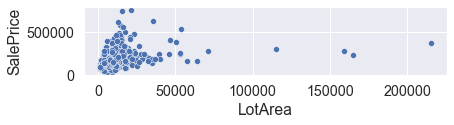

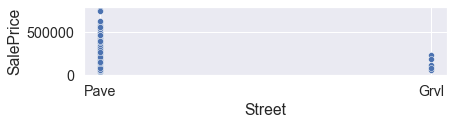

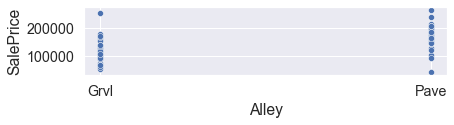

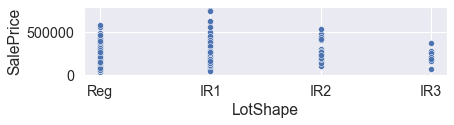

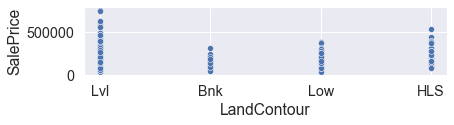

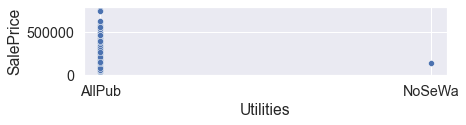

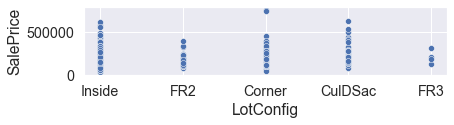

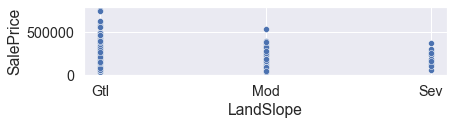

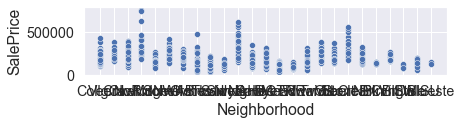

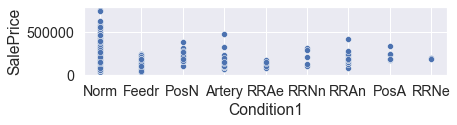

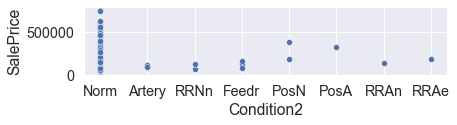

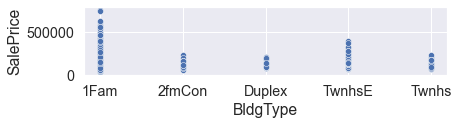

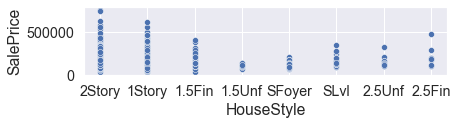

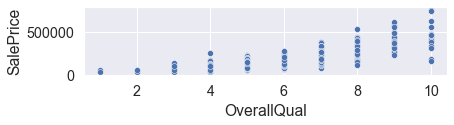

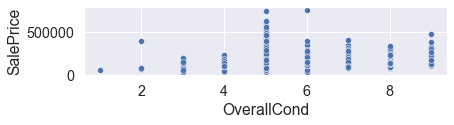

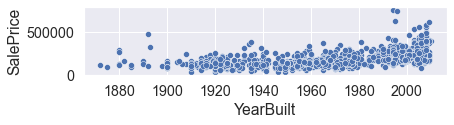

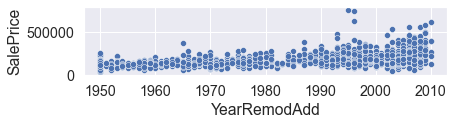

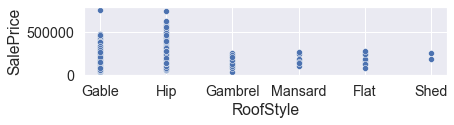

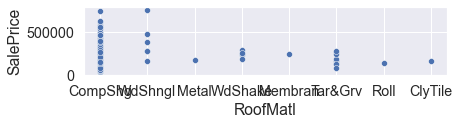

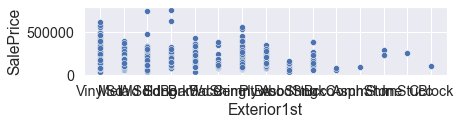

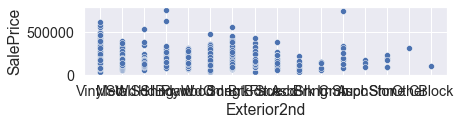

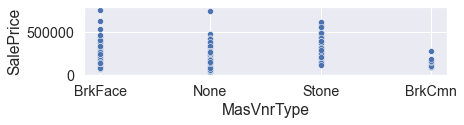

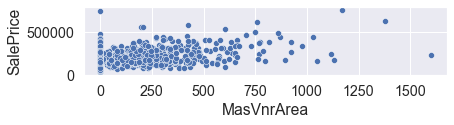

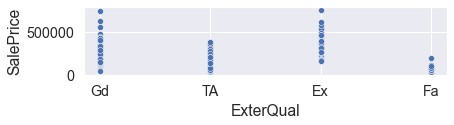

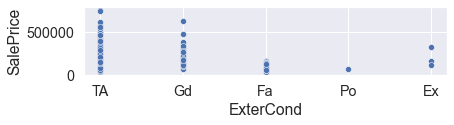

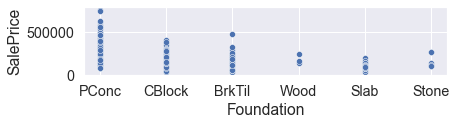

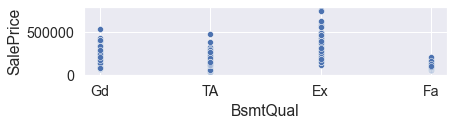

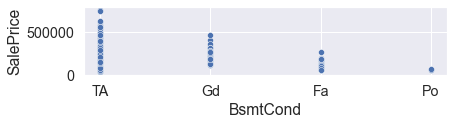

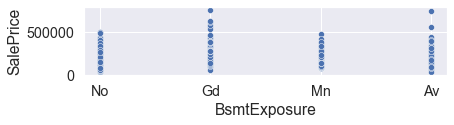

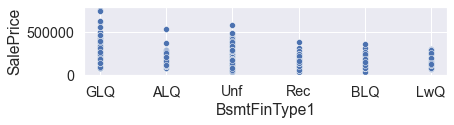

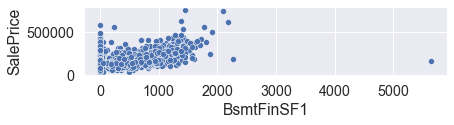

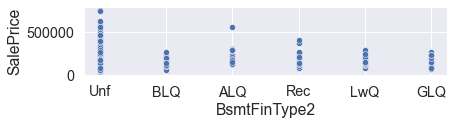

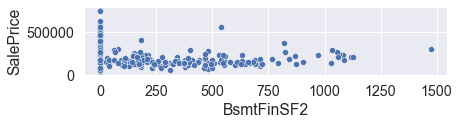

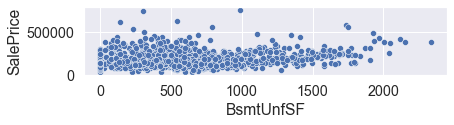

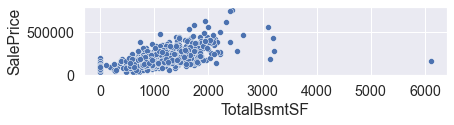

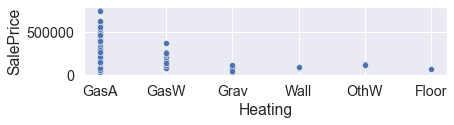

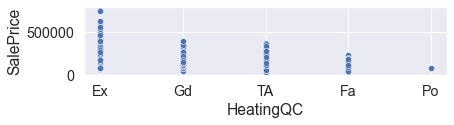

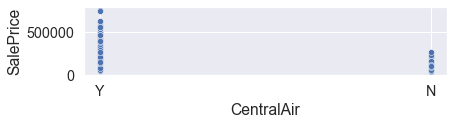

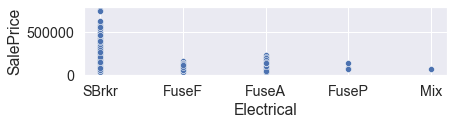

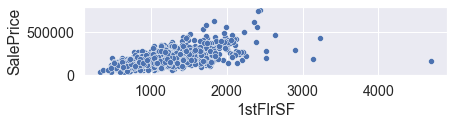

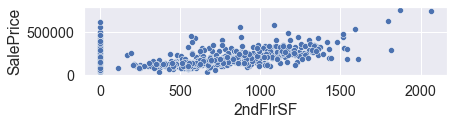

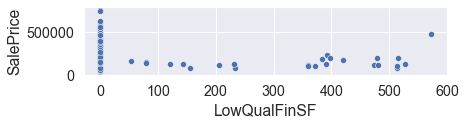

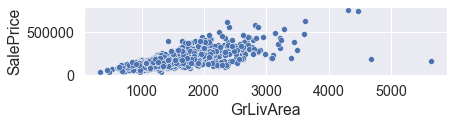

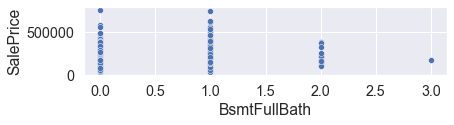

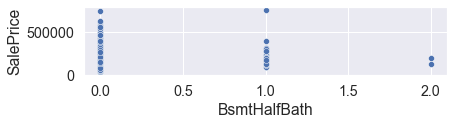

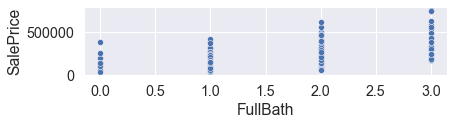

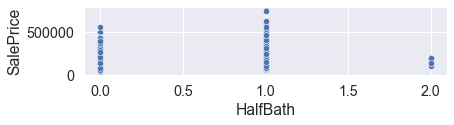

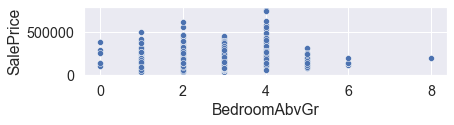

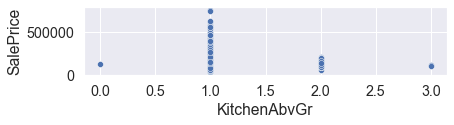

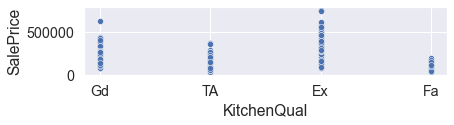

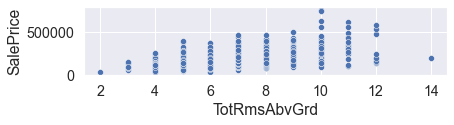

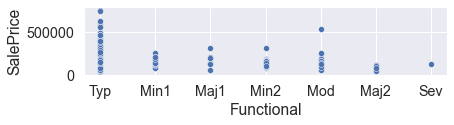

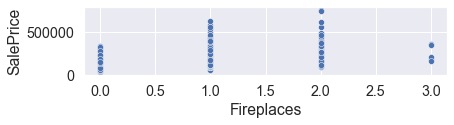

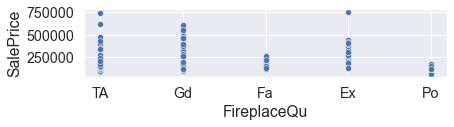

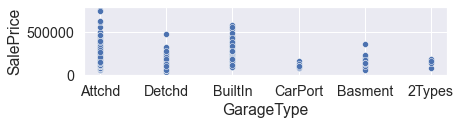

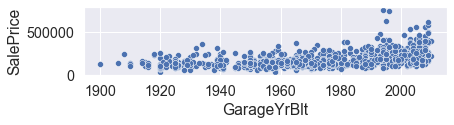

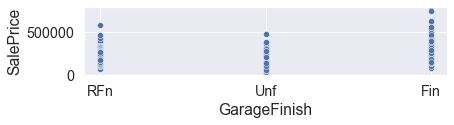

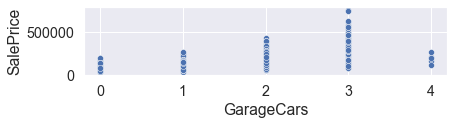

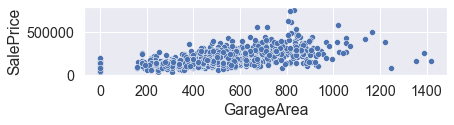

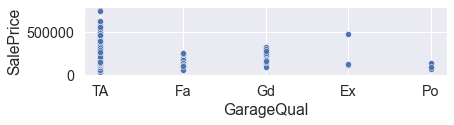

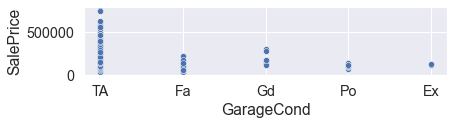

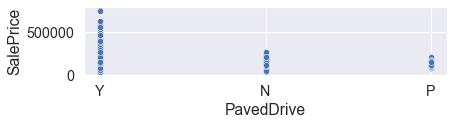

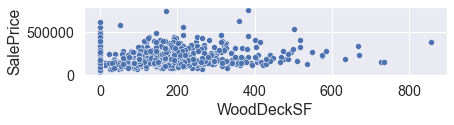

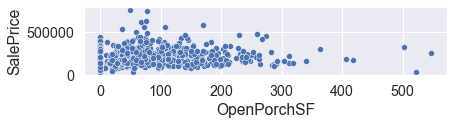

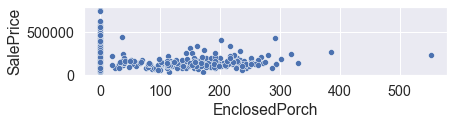

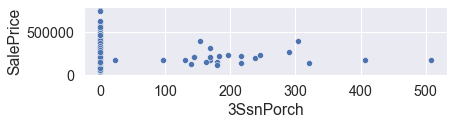

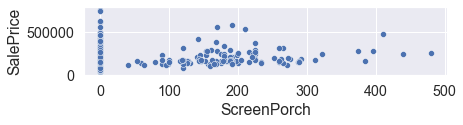

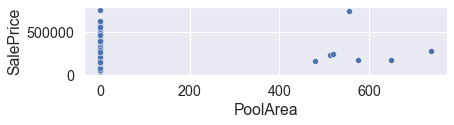

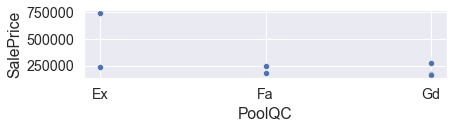

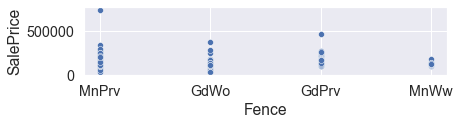

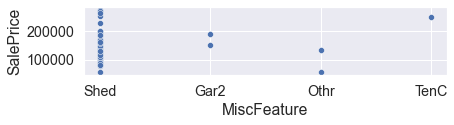

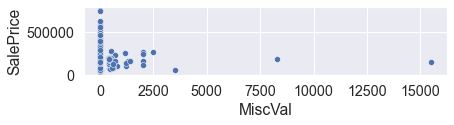

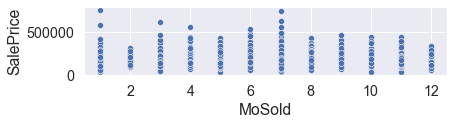

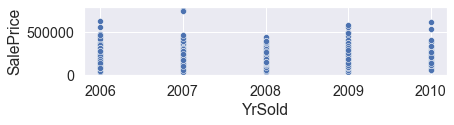

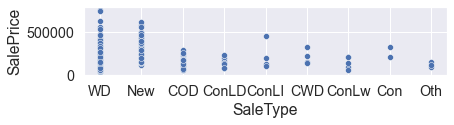

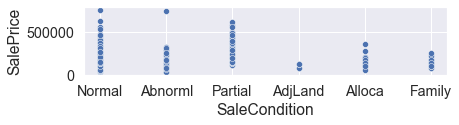

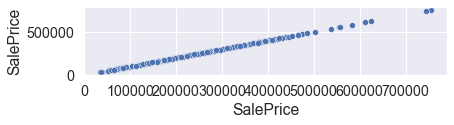

In [48]:
for i,j in enumerate(train.columns):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.scatterplot(train[j],train['SalePrice']);

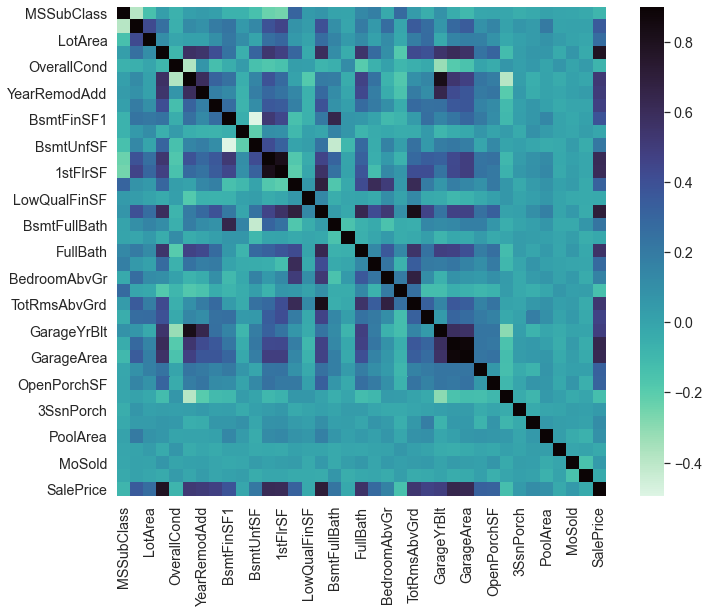

In [49]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'mako_r');


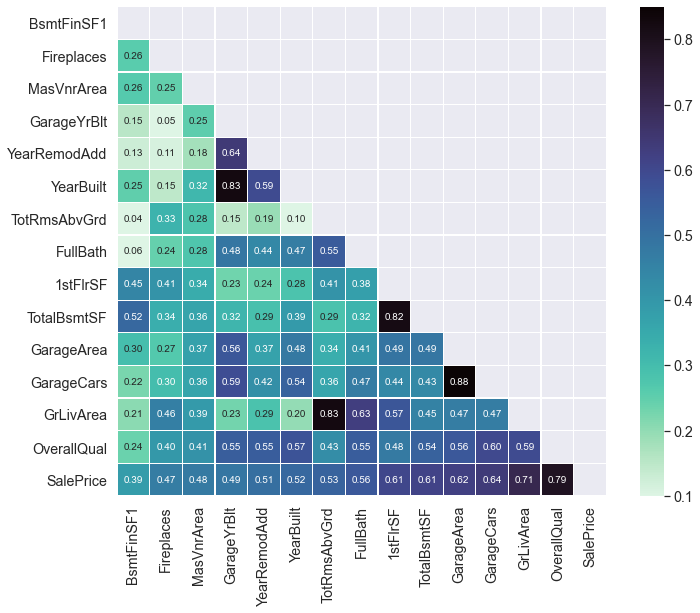

In [50]:
#saleprice correlation matrix
n = 15
#number of parameters for heatmap
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
cols2 = np.array(list(reversed(cols)))
cm = train[cols2].corr()
# mask to get only the upper triangle of the matrix, as the lower one is just repeated information
mask = np.triu(np.ones_like(cm, dtype=np.bool))
# adjust mask and df

cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'mako_r', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)


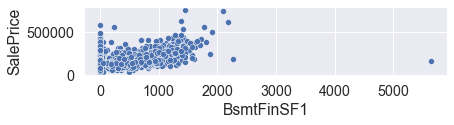

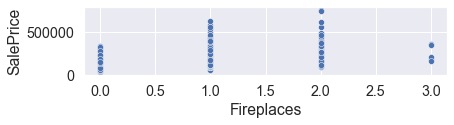

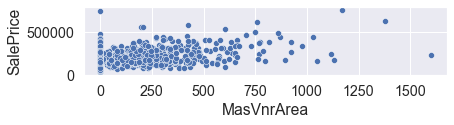

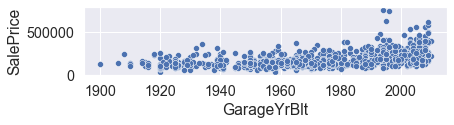

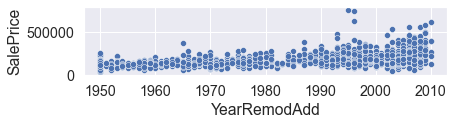

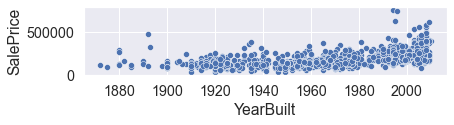

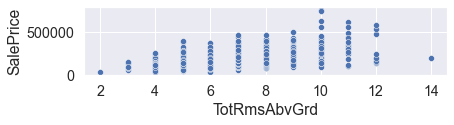

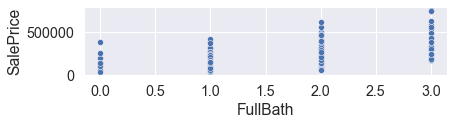

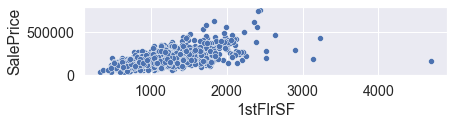

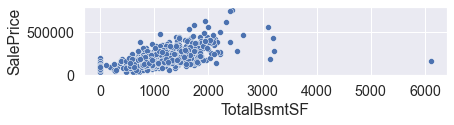

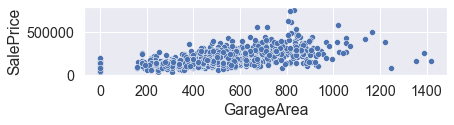

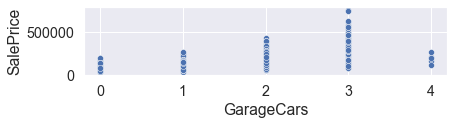

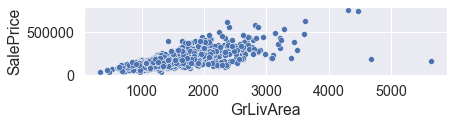

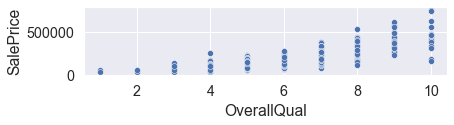

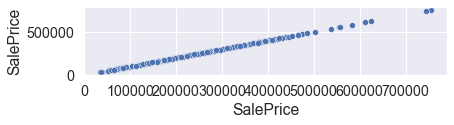

In [51]:
for i,j in enumerate(cols2):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.scatterplot(train[j],train['SalePrice']);

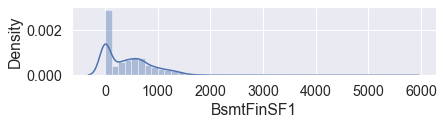

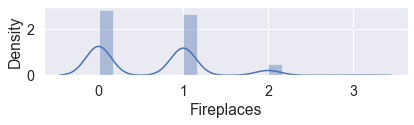

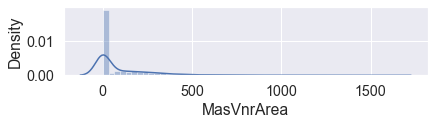

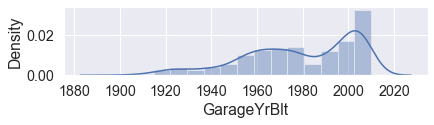

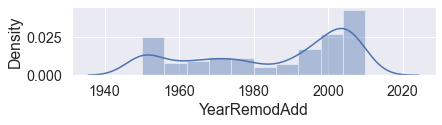

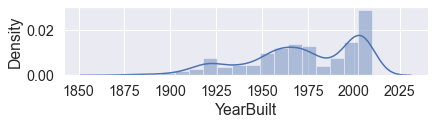

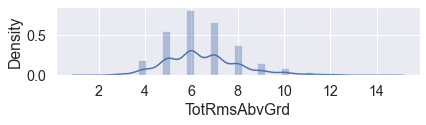

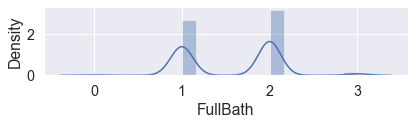

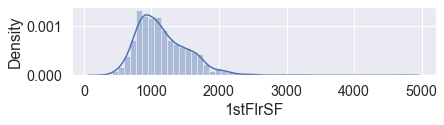

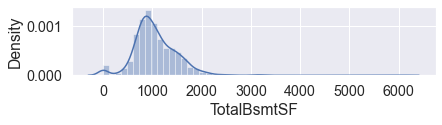

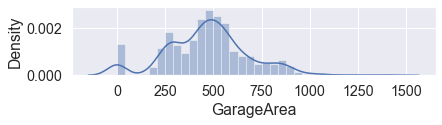

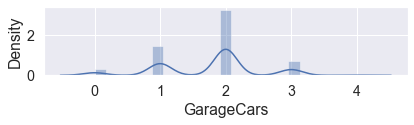

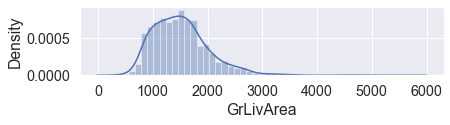

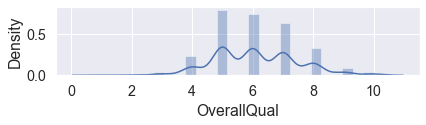

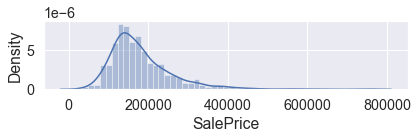

In [52]:
for i,j in enumerate(cols2):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.distplot(train[j]);

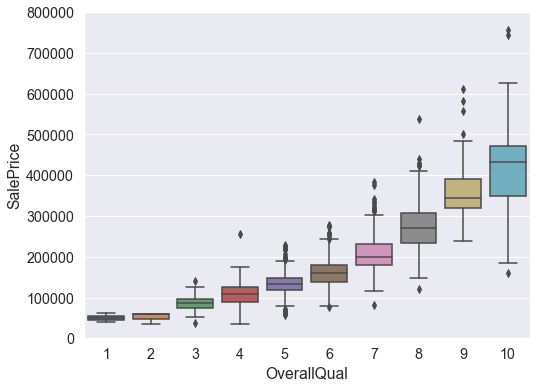

In [53]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);



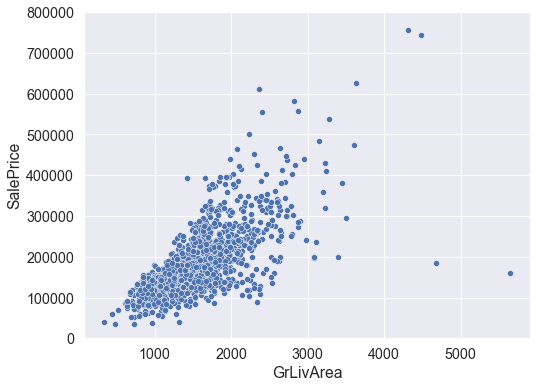

In [54]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x=train['GrLivArea'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);



In [55]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [56]:
# Split features and labels
y = train['SalePrice'].reset_index(drop=True)
X = train.drop(['SalePrice'], axis=1)
print(X.shape)
print(y.shape)

(1457, 79)
(1457,)


Text(0.5, 1.0, 'SalePrice distribution')

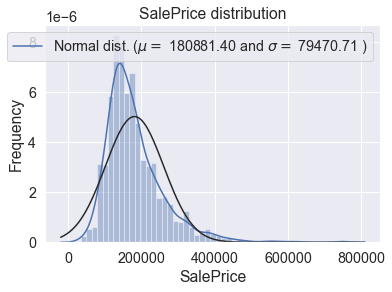

In [57]:

# we will now check SalePrice for its closeness to the normal distribution. 
sns.distplot(y,fit=norm);
(mu, sigma)=norm.fit(y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


Text(0.5, 1.0, 'SalePrice distribution')

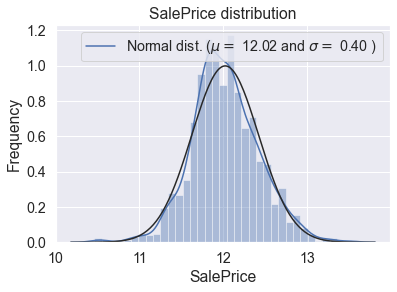

In [58]:
# We need to transform the target variable as linear models favor normlised data

# transforming Sales Price by log (1+x) transformation. This caters for 0 values in the columns
y=np.log1p(y)
# we check the distribution again after the transformation
sns.distplot(y,fit=norm);
(mu, sigma)=norm.fit(y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [59]:
# we will see each column for the type of data present
for i in X.columns:
    print("the category is {} , number of features are {}, they are {}".format(i,X[i].nunique(),X[i].unique()))


the category is MSSubClass , number of features are 15, they are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
the category is MSZoning , number of features are 5, they are ['RL' 'RM' 'C (all)' 'FV' 'RH']
the category is LotFrontage , number of features are 110, they are [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
the category is LotArea , number of features are 1070, they are [ 8450  9600 11250 ... 17217 13175  9717]
the category is Street , number of feature

In [60]:
categorical=[feat for feat in X.columns if X[feat].nunique()<30]

for i in categorical:
    print("the category is {} and number of features are {}".format(i,X[i].unique()))

the category is MSSubClass and number of features are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
the category is MSZoning and number of features are ['RL' 'RM' 'C (all)' 'FV' 'RH']
the category is Street and number of features are ['Pave' 'Grvl']
the category is Alley and number of features are [nan 'Grvl' 'Pave']
the category is LotShape and number of features are ['Reg' 'IR1' 'IR2' 'IR3']
the category is LandContour and number of features are ['Lvl' 'Bnk' 'Low' 'HLS']
the category is Utilities and number of features are ['AllPub' 'NoSeWa']
the category is LotConfig and number of features are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
the category is LandSlope and number of features are ['Gtl' 'Mod' 'Sev']
the category is Neighborhood and number of features are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 '

In [61]:
#### Checking for missing values

data_na=(X.isna().sum()/len(X))*100 # creating a series that has total percentage of missing values

data_na=data_na.drop(data_na[data_na==0].index).sort_values(ascending=False) # filtering the series and sorting

data_na=pd.DataFrame({'Missing':data_na}) # creating dataframe and storing
data_na.head(30)


,Missing
PoolQC,99.588195
MiscFeature,96.293754
Alley,93.754290
Fence,80.713795
FireplaceQu,47.357584
LotFrontage,17.707618
GarageType,5.559369
GarageYrBlt,5.559369
GarageFinish,5.559369
GarageQual,5.559369


In [62]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
X['MSSubClass'] = X['MSSubClass'].apply(str)
X['YrSold'] = X['YrSold'].astype(str)
X['MoSold'] = X['MoSold'].astype(str)

In [63]:
for i in X[['MSSubClass','YrSold','MoSold']].columns:
    print(i, X[i].unique())

MSSubClass ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40']
YrSold ['2008' '2007' '2006' '2009' '2010']
MoSold ['2' '5' '9' '12' '10' '8' '11' '4' '1' '7' '3' '6']


In [64]:
### Handling missing values

#### PoolQC:  categorical ordinal

#PoolQC : data description says NA means "No Pool".Majority of houses have no Pool at all in general. 

X['PoolQC']=X['PoolQC'].fillna('None')
X
#### miscellaneous: categorical nominal

# miscellaneous features: Na means None
X["MiscFeature"] = X["MiscFeature"].fillna("None")
X

#### alley: categorical nominal

#Alley :NA means "no alley access"
X["Alley"] = X["Alley"].fillna("None")

#### fence: categorical nominal

#NA means "no fence"
X["Fence"] = X["Fence"].fillna("None")

#### FireplaceQu: categorical ordinal

#FireplaceQu :NA means "no fireplace"
X["FireplaceQu"] = X["FireplaceQu"].fillna("None")



In [65]:
# checking
for i in X[['PoolQC',"MiscFeature","Alley","Fence","FireplaceQu"]].columns:
    print(i,X[i].unique(),'missing values are {}'.format(X[i].isna().sum()))

PoolQC ['None' 'Ex' 'Fa' 'Gd'] missing values are 0
MiscFeature ['None' 'Shed' 'Gar2' 'Othr' 'TenC'] missing values are 0
Alley ['None' 'Grvl' 'Pave'] missing values are 0
Fence ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] missing values are 0
FireplaceQu ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] missing values are 0


In [66]:

#### LotFrontage: numerical continuous

#fill in missing values by the median LotFrontage (the street area) of the neighborhood.
X['LotFrontage']=X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### GarageFinish, GarageQual and GarageCond: categorical ordinal    GarageType: categorical nominal

#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    X[col] = X[col].fillna('None')

#### GarageYrBlt, GarageArea and GarageCars are all numerical

#GarageYrBlt, GarageArea and GarageCars : Replacing Nan with 0 No garage = no cars in such garage
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X[col] = X[col].fillna(0)

#### basement areas: numerical continuous  , fullbath, half bath: numerical discrete

#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    X[col] = X[col].fillna(0)

#### these are all categorical ordinal

#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 :NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
   X[col] =X[col].fillna('No')

#### masonry area is numeric continuous, type is categorical nominal

#MasVnrArea and MasVnrType : We can fill 0 for the area and None for the type.
X["MasVnrType"] =X["MasVnrType"].fillna("None")
X["MasVnrArea"] = X["MasVnrArea"].fillna(0)



In [67]:
for i in X[['LotFrontage','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars',\
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',\
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
"MasVnrType","MasVnrArea"]].columns:
    print(i, X[i].unique(),'missing values are {}'.format(X[i].isna().sum()))

LotFrontage [ 65.   80.   68.   60.   84.   85.   75.   51.   50.   70.   71.   91.
  73.   72.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.
 115.   66.5  61.   48.   33.   52.  100.   24.   89.   63.   76.   81.
  95.   69.   21.   32.   78.  121.  122.   40.  105.   77.   64.   94.
  34.   90.   55.   88.   82.  120.  107.   92.  134.   62.   86.  141.
  97.   73.5  54.   41.   79.  174.   99.   67.   83.   43.  103.   93.
  30.   64.5 129.  140.   35.   37.  118.   87.  116.  150.  111.   49.
  96.   59.   36.   56.  102.   58.   38.  109.  130.   53.  137.   61.5
  45.  106.  104.   42.   39.  144.  114.  128.  149.  313.  168.  182.
 138.  160.  152.   88.5 124.  153.   46. ] missing values are 0
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types'] missing values are 0
GarageFinish ['RFn' 'Unf' 'Fin' 'None'] missing values are 0
GarageQual ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po'] missing values are 0
GarageCond ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex'] miss

In [68]:
#### mszoning is categorical nominal 

#MSZoning (The general zoning classification) : 'RL' is the mode. So we can fill in missing values with 'RL'
print(X['MSZoning'].mode()[0])


X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])



RL


In [69]:
# checking utilities
X['Utilities'].value_counts()# we can drop this column as there is little information



AllPub    1456
NoSeWa       1
Name: Utilities, dtype: int64

In [70]:
X = X.drop(['Utilities'], axis=1)






In [71]:
#### Functional: categorical nominal
#Functional : data description says NA means typical
X["Functional"] = X["Functional"].fillna("Typ")



In [72]:
#### Electrcal:categorical nominal

# Electrical : Since this feature has mostly 'SBrkr', we can set that for the missing value.

X.Electrical.value_counts()




SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [81]:
X['Electrical'] =X['Electrical'].fillna(X['Electrical'].mode()[0])

In [82]:
X['KitchenQual'] = X['KitchenQual'].fillna("TA")
X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

In [83]:
# check all missing values
pd.set_option('display.max_rows',None)
X.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

In [84]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley','MSSubClass', 'OverallCond','OverallQual', 
        'MoSold']
for i in cols:
    print(i, X[i].unique())
# all ordinal variables

FireplaceQu [0 3 4 2 5 1]
BsmtQual [4 3 5 0 2]
BsmtCond [3 4 0 2 1]
GarageQual [3 2 4 0 5 1]
GarageCond [3 2 0 4 1 5]
ExterQual [4 3 5 2]
ExterCond [3 4 2 1 5]
HeatingQC [5 4 3 2 1]
PoolQC [0 4 1 3]
KitchenQual [4 3 5 2]
BsmtFinType1 [6 5 1 3 4 0 2]
BsmtFinType2 [1 4 0 5 3 2 6]
Functional [8 7 4 6 5 3 2]
Fence [0 3 2 4 1]
BsmtExposure [0 3 1 2]
GarageFinish [2 1 3 0]
LandSlope [3 2 1]
LotShape [4 3 2 1]
PavedDrive [2 0 1]
Street [2 1]
Alley [0 1 2]
MSSubClass [ 6  1  7  5 16  4 11 12  2 10  9 14  8 15  3]
OverallCond [5 8 6 7 4 2 3 9 1]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]


In [85]:
# Encode some categorical features as ordered numbers when there is information in the order
X = X.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "Fence" : {'None':0 ,'MnWw':1,'GdWo':2,'MnPrv': 3, 'GdPrv':4 },
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageFinish": {"None": 0, "Unf":1, "RFn" :2, "Fin": 3},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                       "MSSubClass" :{'60':6, '20':1,'70':7, '50':5, '190':16, '45':4, '90':11, '120':12, '30':2, '85':10, '80':9,'150':13, '160':14, '75':8, '180':15, '40':3},
                       'OverallCond' :{'5':5 ,'8':8,'6':6,'7':7 ,'4':4 ,'2':2 ,'3':3 ,'9':9, '1':1},
                       'OverallQual' :{'7':7, '6':6, '8':8, '5':5, '9':9,'4':4,'10':10, '3':3, '1':1, '2':2},
                       'MoSold' : {'2':2, '5':5,'9':9, '12':12, '10':10, '8':8, '11':11, '4':4, '1':1,'7':7,'3':3,'6':6}

                      }
                     )


In [86]:
for i in X[cols].columns:
    print(i, X[i].unique())

FireplaceQu [0 3 4 2 5 1]
BsmtQual [4 3 5 0 2]
BsmtCond [3 4 0 2 1]
GarageQual [3 2 4 0 5 1]
GarageCond [3 2 0 4 1 5]
ExterQual [4 3 5 2]
ExterCond [3 4 2 1 5]
HeatingQC [5 4 3 2 1]
PoolQC [0 4 1 3]
KitchenQual [4 3 5 2]
BsmtFinType1 [6 5 1 3 4 0 2]
BsmtFinType2 [1 4 0 5 3 2 6]
Functional [8 7 4 6 5 3 2]
Fence [0 3 2 4 1]
BsmtExposure [0 3 1 2]
GarageFinish [2 1 3 0]
LandSlope [3 2 1]
LotShape [4 3 2 1]
PavedDrive [2 0 1]
Street [2 1]
Alley [0 1 2]
MSSubClass [ 6  1  7  5 16  4 11 12  2 10  9 14  8 15  3]
OverallCond [5 8 6 7 4 2 3 9 1]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]


In [87]:
cols_skew=[i for i in X.columns if i not in cols]

In [88]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X[cols_skew].columns:
    if X[i].dtype in numeric_dtypes:
        numeric.append(i)

In [90]:
print(len(X.columns),len(cols),len(cols_skew),len(numeric))


78 25 53 31


In [91]:
# Find skewed numerical features
skew_features = X[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 24 numerical features with Skew > 0.5 :


MiscVal          24.426546
PoolArea         15.927003
LotArea          12.755946
3SsnPorch        10.282886
LowQualFinSF      8.992490
KitchenAbvGr      4.478508
BsmtFinSF2        4.245879
ScreenPorch       4.113045
BsmtHalfBath      4.094248
EnclosedPorch     3.082631
dtype: float64

In [94]:
#We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.
# Normalize skewed features

for i in skew_index:
    X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))

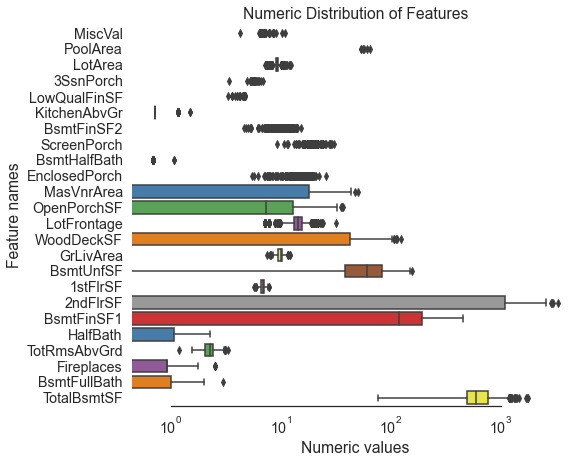

In [95]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=X[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [97]:
skew_features1 = X[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features1[skew_features1 > 5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features1.head(10)

There are 4 numerical features with Skew > 5 :


PoolArea         15.618624
3SsnPorch         7.735939
LowQualFinSF      7.384617
MiscVal           5.194099
KitchenAbvGr      3.948616
BsmtHalfBath      3.920427
ScreenPorch       3.324192
BsmtFinSF2        2.641538
EnclosedPorch     2.282608
MasVnrArea        0.954964
dtype: float64

In [98]:
# creating useful time features
X['YearsSinceRemodel'] = X['YrSold'].astype(int) - X['YearRemodAdd'].astype(int)
X['YrBltAndRemod'] = X['YearRemodAdd']-X['YearBuilt']


In [100]:
for i in X[['YearsSinceRemodel','YrBltAndRemod']].columns:
    print(i, X[i].unique())

YearsSinceRemodel [ 5 31  6 36  8 14  2 58 43  0 46 48 40 39  4 44 57  9 10  1 51 19  3 53
 41 24 28 47 56 52 11 60 21 34  7 42 13 27 12 45 16 25 30 33 54 20 37 50
 15 38 17 32 35 22 18 59 29 49 26 55 23]
YrBltAndRemod [  0   1  55   2  19  11  72   7  20  33  49  40  23  30  36  54   5  88
  16   6  76  29  24  35  53  71  67  85 110  86  18  57  47  43  25  62
  14  15  27  26  78  59  38   9  51  83 101  32   3  39  10  52  50   8
  48  79  58  82  17 122  65  34  75  60  42  77  28  22  61  46  89  80
  13  63  90  70  37 100  44   4  81 107  21  64 111  69  31  68  96 108
  56  92 123  94  45  87  41  74  98  12 103 106  93 104  73 121 115  95
  84]


In [101]:
pd.set_option('display.max_columns',None)
X.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearsSinceRemodel,YrBltAndRemod
0,6,RL,13.809206,9.091255,2,0,4,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.455304,4,3,PConc,4,3,0,6,189.374848,1,0.0,30.309818,521.101103,GasA,5,Y,SBrkr,6.607448,1290.689134,0.0,10.253332,0.994138,0.000000,2,1.071151,3,0.717368,4,2.601966,8,0.000000,0,Attchd,2003.0,2,2,548,3,3,2,0.000000,12.189693,0.000000,0.0,0.0,0.0,0,0,None,0.0,2,2008,WD,Normal,5,0
1,1,RL,15.478222,9.220239,2,0,4,Lvl,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,3,CBlock,4,3,3,5,242.742461,1,0.0,44.679287,743.015090,GasA,5,Y,SBrkr,6.978143,0.000000,0.0,9.701858,0.000000,0.682746,2,0.000000,3,0.717368,3,2.259193,8,0.925372,3,Attchd,1976.0,2,2,460,3,3,2,61.718147,0.000000,0.000000,0.0,0.0,0.0,0,0,None,0.0,5,2007,WD,Normal,31,0
2,6,RL,14.157417,9.380598,2,0,3,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.788194,4,3,PConc,4,3,1,6,142.432771,1,0.0,57.663327,556.600905,GasA,5,Y,SBrkr,6.676363,1310.119601,0.0,10.333406,0.994138,0.000000,2,1.071151,3,0.717368,4,2.259193,8,0.925372,3,Attchd,2001.0,2,2,608,3,3,2,0.000000,9.981247,0.000000,0.0,0.0,0.0,0,0,None,0.0,9,2008,WD,Normal,6,1
3,7,RL,13.210359,9.214960,2,0,3,Lvl,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,3,BrkTil,3,4,0,5,76.570656,1,0.0,65.721328,465.162531,GasA,4,Y,SBrkr,6.718022,1132.758571,0.0,10.260842,0.994138,0.000000,1,0.000000,3,0.717368,4,2.439712,8,0.925372,4,Detchd,1998.0,1,3,642,3,3,2,0.000000,9.034627,19.069317,0.0,0.0,0.0,0,0,None,0.0,2,2006,WD,Abnorml,36,55
4,6,RL,15.895943,9.620371,2,0,3,Lvl,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.437008,4,3,PConc,4,3,2,6,178.853194,1,0.0,62.011144,679.804505,GasA,5,Y,SBrkr,6.885308,1615.249821,0.0,10.719600,0.994138,0.000000,2,1.071151,4,0.717368,4,2.749552,8,0.925372,3,Attchd,2000.0,2,3,836,3,3,2,45.999725,14.412875,0.000000,0.0,0.0,0.0,0,0,None,0.0,12,2008,WD,Normal,8,0


In [102]:
 # converting the entries with/without deck/porch area to 0/1
X['HasWoodDeck'] = (X['WoodDeckSF'] == 0) * 1      
X['HasOpenPorch'] = (X['OpenPorchSF'] == 0) * 1
X['HasEnclosedPorch'] = (X['EnclosedPorch'] == 0) * 1
X['Has3SsnPorch'] = (X['3SsnPorch'] == 0) * 1
X['HasScreenPorch'] = (X['ScreenPorch'] == 0) * 1
X
# creating simple binary columns that indicate if that feature is present
X['haspool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0) 
X['has2ndfloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X['hasgarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X['hasbsmt'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X['hasfireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# 2* Combinations of existing features

# Overall quality of the house
X["TotalHouseGrade"] = X["OverallQual"] * X["OverallCond"]
# Overall quality of the garage
X["GaragXeGrade"] = X["GarageQual"] * X["GarageCond"]
# Overall quality of the exterior
X["ExteriorGrade"] = X["ExterQual"] * X["ExterCond"]
# Overall kitchen score
X["KitchenScore"] = X["KitchenAbvGr"] * X["KitchenQual"]
# Overall fireplace score
X["FireplaceScore"] =X["Fireplaces"] * X["FireplaceQu"]
# Overall garage score
X["GarageScore"] = X["GarageArea"] *X["GarageQual"]
# Overall pool score
X["PoolScore"] = X["PoolArea"] *X["PoolQC"]




# adding up all floor area
X['TotalSF'] =X["GrLivArea"] +X["TotalBsmtSF"]
# Total area for 1st + 2nd floors
X["TotalFlrsSF"] =X['BsmtFinSF1'] +X['BsmtFinSF2']+ X["1stFlrSF"] +X["2ndFlrSF"]
# Total area for porch
X["AllPorchSF"] =X["OpenPorchSF"] + X["EnclosedPorch"] + \
X["3SsnPorch"] + X["ScreenPorch"]
X
# Total number of bathrooms
# total bathrooms with more weightage given to full sized
X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) +\
                             X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))


# Has masonry veneer or not
X["HasMasVnr"] = X.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, \
                                              "Stone" : 1, "None" : 0})
# House completed before sale or not
X["BoughtOffPlan"] =X.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,\
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})


In [103]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearsSinceRemodel,YrBltAndRemod,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,TotalHouseGrade,GaragXeGrade,ExteriorGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalSF,TotalFlrsSF,AllPorchSF,Total_Bathrooms,HasMasVnr,BoughtOffPlan
0,6,RL,13.809206,9.091255,2,0,4,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.455304,4,3,PConc,4,3,0,6,189.374848,1,0.0,30.309818,521.101103,GasA,5,Y,SBrkr,6.607448,1290.689134,0.0,10.253332,0.994138,0.000000,2,1.071151,3,0.717368,4,2.601966,8,0.000000,0,Attchd,2003.0,2,2,548,3,3,2,0.000000,12.189693,0.000000,0.0,0.0,0.0,0,0,None,0.0,2,2008,WD,Normal,5,0,1,0,1,1,1,0,1,1,1,0,35,9,12,2.869471,0.000000,1644,0.0,531.354435,1486.671430,12.189693,3.529713,1,0
1,1,RL,15.478222,9.220239,2,0,4,Lvl,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,3,CBlock,4,3,3,5,242.742461,1,0.0,44.679287,743.015090,GasA,5,Y,SBrkr,6.978143,0.000000,0.0,9.701858,0.000000,0.682746,2,0.000000,3,0.717368,3,2.259193,8,0.925372,3,Attchd,1976.0,2,2,460,3,3,2,61.718147,0.000000,0.000000,0.0,0.0,0.0,0,0,None,0.0,5,2007,WD,Normal,31,0,0,1,1,1,1,0,0,1,1,1,48,9,9,2.152103,2.776115,1380,0.0,752.716947,249.720604,0.000000,2.341373,0,0
2,6,RL,14.157417,9.380598,2,0,3,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.788194,4,3,PConc,4,3,1,6,142.432771,1,0.0,57.663327,556.600905,GasA,5,Y,SBrkr,6.676363,1310.119601,0.0,10.333406,0.994138,0.000000,2,1.071151,3,0.717368,4,2.259193,8,0.925372,3,Attchd,2001.0,2,2,608,3,3,2,0.000000,9.981247,0.000000,0.0,0.0,0.0,0,0,None,0.0,9,2008,WD,Normal,6,1,1,0,1,1,1,0,1,1,1,1,35,9,12,2.869471,2.776115,1824,0.0,566.934310,1459.228735,9.981247,3.529713,1,0
3,7,RL,13.210359,9.214960,2,0,3,Lvl,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,3,BrkTil,3,4,0,5,76.570656,1,0.0,65.721328,465.162531,GasA,4,Y,SBrkr,6.718022,1132.758571,0.0,10.260842,0.994138,0.000000,1,0.000000,3,0.717368,4,2.439712,8,0.925372,4,Detchd,1998.0,1,3,642,3,3,2,0.000000,9.034627,19.069317,0.0,0.0,0.0,0,0,None,0.0,2,2006,WD,Abnorml,36,55,1,0,0,1,1,0,1,1,1,1,35,9,9,2.869471,3.701487,1926,0.0,475.423373,1216.047249,28.103944,1.994138,0,0
4,6,RL,15.895943,9.620371,2,0,3,Lvl,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.437008,4,3,PConc,4,3,2,6,178.853194,1,0.0,62.011144,679.804505,GasA,5,Y,SBrkr,6.885308,1615.249821,0.0,10.719600,0.994138,0.000000,2,1.071151,4,0.717368,4,2.749552,8,0.925372,3,Attchd,2000.0,2,3,836,3,3,2,45.999725,14.412875,0.000000,0.0,0.0,0.0,0,0,None,0.0,12,2008,WD,Normal,8,0,0,0,1,1,1,0,1,1,1,1,40,9,12,2.869471,2.776115,2508,0.0,690.524104,1800.988324,14.412875,3.529713,1,0


In [104]:
categorical_features=X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude = ["object"]).columns
cat_df=X[categorical_features]
num_df=X[numerical_features]

In [105]:
cat_df.head()

,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,YrSold,SaleType,SaleCondition
0,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal
1,RL,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,Attchd,None,2007,WD,Normal
2,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal
3,RL,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,Detchd,None,2006,WD,Abnorml
4,RL,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal


In [106]:
num_df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YearsSinceRemodel,YrBltAndRemod,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,TotalHouseGrade,GaragXeGrade,ExteriorGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalSF,TotalFlrsSF,AllPorchSF,Total_Bathrooms,HasMasVnr,BoughtOffPlan
0,6,13.809206,9.091255,2,0,4,3,7,5,2003,2003,19.455304,4,3,4,3,0,6,189.374848,1,0.0,30.309818,521.101103,5,6.607448,1290.689134,0.0,10.253332,0.994138,0.000000,2,1.071151,3,0.717368,4,2.601966,8,0.000000,0,2003.0,2,2,548,3,3,2,0.000000,12.189693,0.000000,0.0,0.0,0.0,0,0,0.0,2,5,0,1,0,1,1,1,0,1,1,1,0,35,9,12,2.869471,0.000000,1644,0.0,531.354435,1486.671430,12.189693,3.529713,1,0
1,1,15.478222,9.220239,2,0,4,3,6,8,1976,1976,0.000000,3,3,4,3,3,5,242.742461,1,0.0,44.679287,743.015090,5,6.978143,0.000000,0.0,9.701858,0.000000,0.682746,2,0.000000,3,0.717368,3,2.259193,8,0.925372,3,1976.0,2,2,460,3,3,2,61.718147,0.000000,0.000000,0.0,0.0,0.0,0,0,0.0,5,31,0,0,1,1,1,1,0,0,1,1,1,48,9,9,2.152103,2.776115,1380,0.0,752.716947,249.720604,0.000000,2.341373,0,0
2,6,14.157417,9.380598,2,0,3,3,7,5,2001,2002,17.788194,4,3,4,3,1,6,142.432771,1,0.0,57.663327,556.600905,5,6.676363,1310.119601,0.0,10.333406,0.994138,0.000000,2,1.071151,3,0.717368,4,2.259193,8,0.925372,3,2001.0,2,2,608,3,3,2,0.000000,9.981247,0.000000,0.0,0.0,0.0,0,0,0.0,9,6,1,1,0,1,1,1,0,1,1,1,1,35,9,12,2.869471,2.776115,1824,0.0,566.934310,1459.228735,9.981247,3.529713,1,0
3,7,13.210359,9.214960,2,0,3,3,7,5,1915,1970,0.000000,3,3,3,4,0,5,76.570656,1,0.0,65.721328,465.162531,4,6.718022,1132.758571,0.0,10.260842,0.994138,0.000000,1,0.000000,3,0.717368,4,2.439712,8,0.925372,4,1998.0,1,3,642,3,3,2,0.000000,9.034627,19.069317,0.0,0.0,0.0,0,0,0.0,2,36,55,1,0,0,1,1,0,1,1,1,1,35,9,9,2.869471,3.701487,1926,0.0,475.423373,1216.047249,28.103944,1.994138,0,0
4,6,15.895943,9.620371,2,0,3,3,8,5,2000,2000,25.437008,4,3,4,3,2,6,178.853194,1,0.0,62.011144,679.804505,5,6.885308,1615.249821,0.0,10.719600,0.994138,0.000000,2,1.071151,4,0.717368,4,2.749552,8,0.925372,3,2000.0,2,3,836,3,3,2,45.999725,14.412875,0.000000,0.0,0.0,0.0,0,0,0.0,12,8,0,0,0,1,1,1,0,1,1,1,1,40,9,12,2.869471,2.776115,2508,0.0,690.524104,1800.988324,14.412875,3.529713,1,0


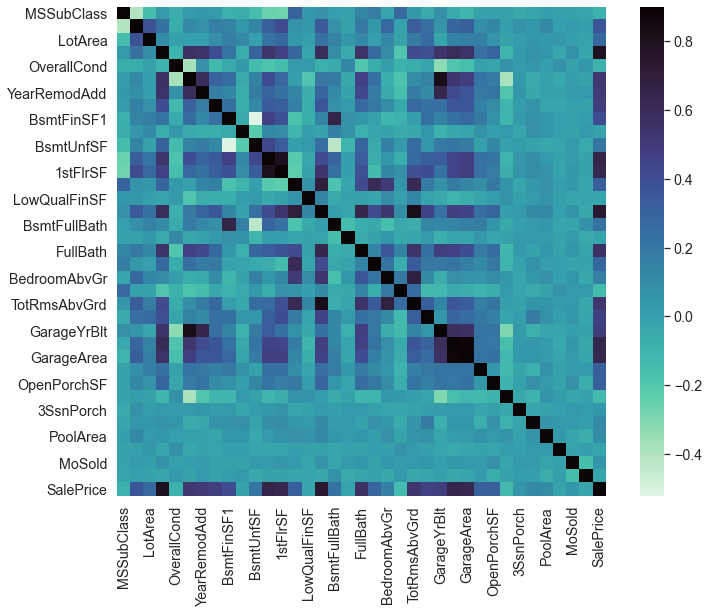

In [107]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'mako_r');


In [116]:
cols=np.array(list(reversed(corrmat.nlargest(15,'SalePrice')['SalePrice'].index)))  # creating an array of highest correlation variables


In [117]:
cm=train[cols].corr()

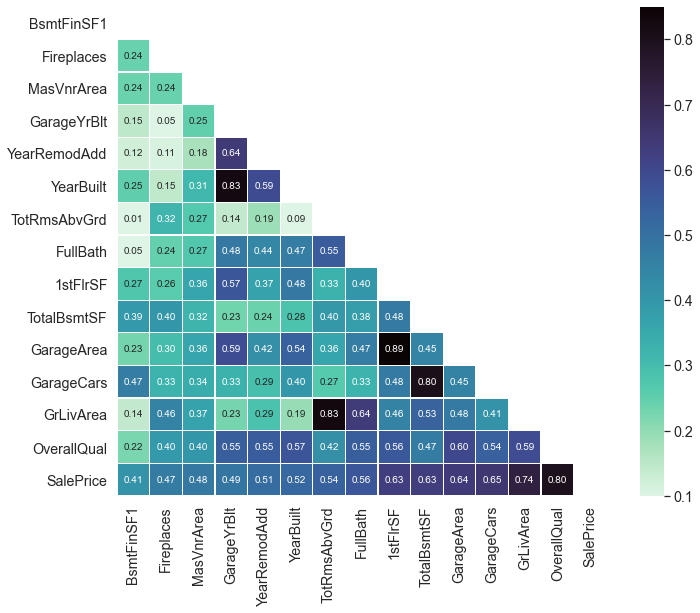

In [123]:
mask=np.triu(np.ones_like(cm, dtype=np.bool))
cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'mako_r', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)


In [126]:
polycols=[cols for cols in cols if cols !='SalePrice']

In [127]:
polycols

['BsmtFinSF1',
 'Fireplaces',
 'MasVnrArea',
 'GarageYrBlt',
 'YearRemodAdd',
 'YearBuilt',
 'TotRmsAbvGrd',
 'FullBath',
 'GarageArea',
 '1stFlrSF',
 'GarageCars',
 'TotalBsmtSF',
 'GrLivArea',
 'OverallQual']

In [129]:


from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=4)
higher=poly.fit_transform(num_df[polycols])
names=poly.get_feature_names(polycols)
high=pd.DataFrame(higher,columns=names)

In [130]:
num_df.shape

(1457, 81)

In [131]:
high.reset_index(drop=True, inplace=True)

In [132]:
new_num_df=pd.concat([num_df,high],axis=1)

In [133]:
new_num_df.shape

(1457, 3141)

In [135]:
final_col_names=new_num_df.columns

In [136]:
from sklearn.preprocessing import RobustScaler
robust=RobustScaler()
new_num_df=robust.fit_transform(new_num_df)
new_num_df=pd.DataFrame(new_num_df,columns=final_col_names)



In [137]:
new_num_df.shape

(1457, 3141)

In [146]:
# checking few columns
new_num_df.iloc[0:6,1000:1100]

,BsmtFinSF1 MasVnrArea TotRmsAbvGrd FullBath,BsmtFinSF1 MasVnrArea TotRmsAbvGrd GarageArea,BsmtFinSF1 MasVnrArea TotRmsAbvGrd 1stFlrSF,BsmtFinSF1 MasVnrArea TotRmsAbvGrd GarageCars,BsmtFinSF1 MasVnrArea TotRmsAbvGrd TotalBsmtSF,BsmtFinSF1 MasVnrArea TotRmsAbvGrd GrLivArea,BsmtFinSF1 MasVnrArea TotRmsAbvGrd OverallQual,BsmtFinSF1 MasVnrArea FullBath^2,BsmtFinSF1 MasVnrArea FullBath GarageArea,BsmtFinSF1 MasVnrArea FullBath 1stFlrSF,BsmtFinSF1 MasVnrArea FullBath GarageCars,BsmtFinSF1 MasVnrArea FullBath TotalBsmtSF,BsmtFinSF1 MasVnrArea FullBath GrLivArea,BsmtFinSF1 MasVnrArea FullBath OverallQual,BsmtFinSF1 MasVnrArea GarageArea^2,BsmtFinSF1 MasVnrArea GarageArea 1stFlrSF,BsmtFinSF1 MasVnrArea GarageArea GarageCars,BsmtFinSF1 MasVnrArea GarageArea TotalBsmtSF,BsmtFinSF1 MasVnrArea GarageArea GrLivArea,BsmtFinSF1 MasVnrArea GarageArea OverallQual,BsmtFinSF1 MasVnrArea 1stFlrSF^2,BsmtFinSF1 MasVnrArea 1stFlrSF GarageCars,BsmtFinSF1 MasVnrArea 1stFlrSF TotalBsmtSF,BsmtFinSF1 MasVnrArea 1stFlrSF GrLivArea,BsmtFinSF1 MasVnrArea 1stFlrSF OverallQual,BsmtFinSF1 MasVnrArea GarageCars^2,BsmtFinSF1 MasVnrArea GarageCars TotalBsmtSF,BsmtFinSF1 MasVnrArea GarageCars GrLivArea,BsmtFinSF1 MasVnrArea GarageCars OverallQual,BsmtFinSF1 MasVnrArea TotalBsmtSF^2,BsmtFinSF1 MasVnrArea TotalBsmtSF GrLivArea,BsmtFinSF1 MasVnrArea TotalBsmtSF OverallQual,BsmtFinSF1 MasVnrArea GrLivArea^2,BsmtFinSF1 MasVnrArea GrLivArea OverallQual,BsmtFinSF1 MasVnrArea OverallQual^2,BsmtFinSF1 GarageYrBlt^3,BsmtFinSF1 GarageYrBlt^2 YearRemodAdd,BsmtFinSF1 GarageYrBlt^2 YearBuilt,BsmtFinSF1 GarageYrBlt^2 TotRmsAbvGrd,BsmtFinSF1 GarageYrBlt^2 FullBath,BsmtFinSF1 GarageYrBlt^2 GarageArea,BsmtFinSF1 GarageYrBlt^2 1stFlrSF,BsmtFinSF1 GarageYrBlt^2 GarageCars,BsmtFinSF1 GarageYrBlt^2 TotalBsmtSF,BsmtFinSF1 GarageYrBlt^2 GrLivArea,BsmtFinSF1 GarageYrBlt^2 OverallQual,BsmtFinSF1 GarageYrBlt YearRemodAdd^2,BsmtFinSF1 GarageYrBlt YearRemodAdd YearBuilt,BsmtFinSF1 GarageYrBlt YearRemodAdd TotRmsAbvGrd,BsmtFinSF1 GarageYrBlt YearRemodAdd FullBath,BsmtFinSF1 GarageYrBlt YearRemodAdd GarageArea,BsmtFinSF1 GarageYrBlt YearRemodAdd 1stFlrSF,BsmtFinSF1 GarageYrBlt YearRemodAdd GarageCars,BsmtFinSF1 GarageYrBlt YearRemodAdd TotalBsmtSF,BsmtFinSF1 GarageYrBlt YearRemodAdd GrLivArea,BsmtFinSF1 GarageYrBlt YearRemodAdd OverallQual,BsmtFinSF1 GarageYrBlt YearBuilt^2,BsmtFinSF1 GarageYrBlt YearBuilt TotRmsAbvGrd,BsmtFinSF1 GarageYrBlt YearBuilt FullBath,BsmtFinSF1 GarageYrBlt YearBuilt GarageArea,BsmtFinSF1 GarageYrBlt YearBuilt 1stFlrSF,BsmtFinSF1 GarageYrBlt YearBuilt GarageCars,BsmtFinSF1 GarageYrBlt YearBuilt TotalBsmtSF,BsmtFinSF1 GarageYrBlt YearBuilt GrLivArea,BsmtFinSF1 GarageYrBlt YearBuilt OverallQual,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd^2,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd FullBath,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd GarageArea,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd 1stFlrSF,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd GarageCars,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd TotalBsmtSF,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd GrLivArea,BsmtFinSF1 GarageYrBlt TotRmsAbvGrd OverallQual,BsmtFinSF1 GarageYrBlt FullBath^2,BsmtFinSF1 GarageYrBlt FullBath GarageArea,BsmtFinSF1 GarageYrBlt FullBath 1stFlrSF,BsmtFinSF1 GarageYrBlt FullBath GarageCars,BsmtFinSF1 GarageYrBlt FullBath TotalBsmtSF,BsmtFinSF1 GarageYrBlt FullBath GrLivArea,BsmtFinSF1 GarageYrBlt FullBath OverallQual,BsmtFinSF1 GarageYrBlt GarageArea^2,BsmtFinSF1 GarageYrBlt GarageArea 1stFlrSF,BsmtFinSF1 GarageYrBlt GarageArea GarageCars,BsmtFinSF1 GarageYrBlt GarageArea TotalBsmtSF,BsmtFinSF1 GarageYrBlt GarageArea GrLivArea,BsmtFinSF1 GarageYrBlt GarageArea OverallQual,BsmtFinSF1 GarageYrBlt 1stFlrSF^2,BsmtFinSF1 GarageYrBlt 1stFlrSF GarageCars,BsmtFinSF1 GarageYrBlt 1stFlrSF TotalBsmtSF,BsmtFinSF1 GarageYrBlt 1stFlrSF GrLivArea,BsmtFinSF1 GarageYrBlt 1stFlrSF OverallQual,BsmtFinSF1 GarageYrBlt GarageCars^2,BsmtFinSF1 GarageYrBlt GarageCars TotalBsmtSF,BsmtFinSF1 GarageYrBlt GarageCars GrLivArea,BsmtFinSF1 GarageYrBlt GarageCars OverallQual,BsmtFinS

In [147]:
new_num_df.reset_index(drop=True, inplace=True)

In [148]:
cat_df=pd.get_dummies(cat_df)

In [149]:
cat_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [150]:
cat_df.reset_index(drop=True, inplace=True)

In [151]:
full_df=pd.concat([new_num_df,cat_df],axis=1)

In [152]:
full_df.shape

(1457, 3309)

In [154]:
y.shape    # X and y dimensionality check

(1457,)

In [155]:
full_df = full_df.loc[:,~full_df.columns.duplicated()]  # Removing duplicate columns after dummy features

In [156]:
full_df.shape   # note few columns were removed

(1457, 3295)

In [157]:
# creating validation set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(full_df,y,test_size=0.3,random_state=100)

In [159]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1019, 3295)
(1019,)
(438, 3295)
(438,)


In [165]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV,Lasso
from sklearn.metrics import r2_score, mean_squared_error
kf = KFold(n_splits=3, random_state=42, shuffle=True)
# Define error metrics

def cv_r2(model, X,y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kf,verbose=3,n_jobs=-1)
    return (r2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out

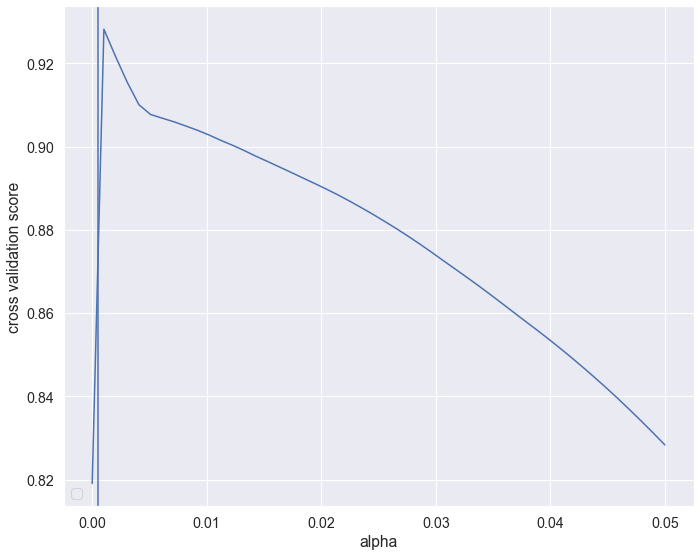

In [171]:
alphas = np.linspace(0,0.05,50)

plt.figure(figsize=(10, 8))


scores = [cross_val_score(Lasso(alpha), X_train, y_train,n_jobs=-1, cv=3,verbose=2).mean()\
            for alpha in alphas]
plt.plot(alphas, scores)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.axvline(x=0.0005,)
plt.tight_layout()
plt.show()


#### We can see that the best r2 is between 0 and 0.01

In [193]:
# lasso Regressor
alpha=np.linspace(0,0.001,100)
las= LassoCV(alphas=alpha, cv=kf)

In [194]:
las.fit(X_train,y_train)

LassoCV(alphas=array([0.00000000e+00, 1.01010101e-05, 2.02020202e-05, 3.03030303e-05,
       4.04040404e-05, 5.05050505e-05, 6.06060606e-05, 7.07070707e-05,
       8.08080808e-05, 9.09090909e-05, 1.01010101e-04, 1.11111111e-04,
       1.21212121e-04, 1.31313131e-04, 1.41414141e-04, 1.51515152e-04,
       1.61616162e-04, 1.71717172e-04, 1.81818182e-04, 1.91919192e-04,
       2.02020202e-04, 2.12121212e-0...
       8.08080808e-04, 8.18181818e-04, 8.28282828e-04, 8.38383838e-04,
       8.48484848e-04, 8.58585859e-04, 8.68686869e-04, 8.78787879e-04,
       8.88888889e-04, 8.98989899e-04, 9.09090909e-04, 9.19191919e-04,
       9.29292929e-04, 9.39393939e-04, 9.49494949e-04, 9.59595960e-04,
       9.69696970e-04, 9.79797980e-04, 9.89898990e-04, 1.00000000e-03]),
        cv=KFold(n_splits=3, random_state=42, shuffle=True))

In [195]:
las.alpha_

0.0009191919191919192

Lasso picked 144 features and eliminated the other 3151 features


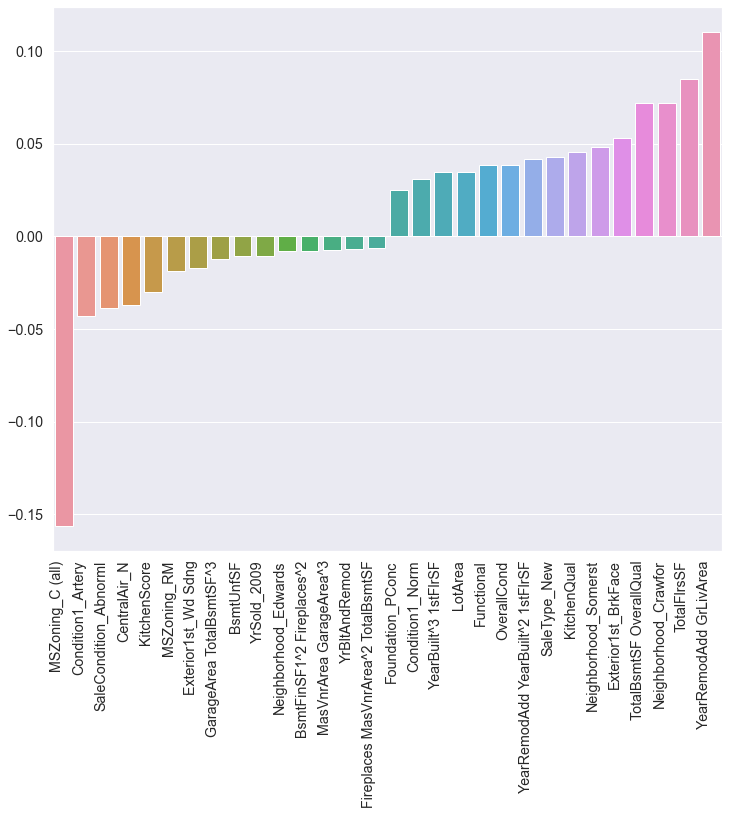

In [196]:
coefs = pd.Series(las.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
# imp_coefs.plot(kind = "barh");
# plt.title("Coefficients in the Ridge Model")
# plt.yticks(rotation=0)

# plt.figure(figsize=(25,20))
# plt.show()
plt.figure(figsize=(12,10))

bar=sns.barplot(imp_coefs.index,imp_coefs.values)
bar.set_xticklabels(bar.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

In [197]:
y_train_pred=las.predict(X_train)

In [198]:
print('r2 for train data is {} and RMSE is {}'.format(r2_score(y_train,y_train_pred),np.sqrt(mean_squared_error(y_train,y_train_pred))))

r2 for train data is 0.9482847931754296 and RMSE is 0.08992224336543356


In [199]:
y_test_pred=las.predict(X_test)

In [200]:
print('r2 for test data is {} and RMSE is {}'.format(r2_score(y_test,y_test_pred),np.sqrt(mean_squared_error(y_test,y_test_pred))))

r2 for test data is 0.9079487980998591 and RMSE is 0.12408234915052696


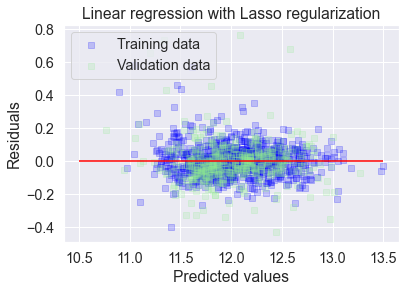

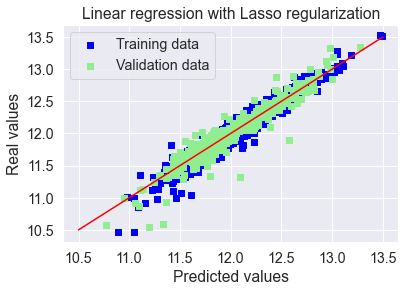

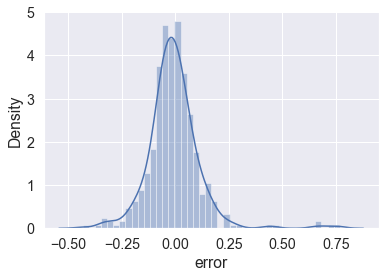

In [201]:
#Plot residuals


plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data",alpha=0.2)
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data",alpha=0.2)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

sns.distplot((y_test_pred - y_test),axlabel='error');

In [106]:
y_test_pred=np.expm1(las.predict(X_test))

In [108]:
y_test_pred[:5]

array([116704.42834635, 158120.78475111, 183995.90319495, 201281.40908811,
       186237.85919465])

In [110]:
submission.iloc[:,1]=y_test_pred

In [ ]:
submission.to_csv('submission_lasso.csv',index=False)